In [1]:
import os, sys, time
import uproot3 as uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numbers import Integral
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, truncnorm, foldnorm
import warnings
from time import perf_counter
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

from farich_functions import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
datadir = 'data'

In [4]:
filepath = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_no.root')
filepath_fixed = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_fixed.root')
filepath_2pi = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_2pi_phi.root')
filepath_prototype = os.path.join(datadir, 'farichsim_10kevt.root')
filepath_new = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_spectre_test_3.root')

In [5]:
# file = uproot.open(filepath)
file = uproot.open(filepath_fixed)
# file_2pi = uproot.open(filepath_2pi)
file_prototype = uproot.open(filepath_prototype)
# file_new = uproot.open(filepath_new)

In [6]:
plt.style.use('default')

In [ ]:
plot_cyl(file, transposed=True)

In [52]:
np.concatenate(np.array(file['events;1']['FarichBarrelG4Hits.postStepPosition.x'].array())).shape

(470755,)

# Main (tmp obv)

In [7]:
norm_r = 1007.0091186826339

In [8]:
pdes_tmp = pd.read_csv('PDE.csv', sep=';', names=['A'])
t1 = []
t2 = []
for inedx, row in pdes_tmp.iterrows():
    t1.append(float(row['A'].split(';')[0].replace(',', '.')))
    t2.append(float(row['A'].split(';')[1].replace(',', '.')))
PDE_wvs = np.linspace(200, 900, 128)
PDEs = np.interp(PDE_wvs, t1, t2, left=0, right=0)
# sipm_eff = {key: value for key, value in zip(PDE_wvs, PDEs)}
sipm_eff = fix_PDE_plot(PDEs, PDE_wvs)

In [9]:
x_grid = np.arange(-3*norm_r * np.sin(np.pi / 27), 3*norm_r * np.sin(np.pi / 27), SIPM_CELL_SIZE)
# x_grid = np.arange(-norm_r * np.sin(np.pi / 27), norm_r * np.sin(np.pi / 27), 3.16)
z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
grid = (x_grid, z_grid, PDE_wvs)

In [10]:
x = np.array(file['events;2']['FarichBarrelG4Hits.postStepPosition.x'].array())
y = np.array(file['events;2']['FarichBarrelG4Hits.postStepPosition.y'].array())
z = np.array(file['events;2']['FarichBarrelG4Hits.postStepPosition.z'].array())
wvs = 1239.841 / np.array(file['events;2']['FarichBarrelG4Hits.energy'].array()) * 1e-9

In [11]:
x1 = np.array(file['events;2']['DriftChamberG4Hits.postStepPosition.x'].array())
y1 = np.array(file['events;2']['DriftChamberG4Hits.postStepPosition.y'].array())
z1 = np.array(file['events;2']['DriftChamberG4Hits.postStepPosition.z'].array())
drift_chamber_coordinates = np.column_stack((x1, y1, z1))

In [12]:
x2 = np.array(file['events;2']['TPCG4Hits.postStepPosition.x'].array())
y2 = np.array(file['events;2']['TPCG4Hits.postStepPosition.y'].array())
z2 = np.array(file['events;2']['TPCG4Hits.postStepPosition.z'].array())
tpc_coordinates = np.column_stack((x2, y2, z2))

In [13]:
x3 = np.array(file['events;2']['allGenParticles.core.p4.px'].array())
y3 = np.array(file['events;2']['allGenParticles.core.p4.py'].array())
z3 = np.array(file['events;2']['allGenParticles.core.p4.pz'].array())
true_direction_coordinates = np.column_stack((x3, y3, z3))

In [14]:
for i in range(len(wvs)):
    wvs[i] = lin_move_to_grid(wvs[i], grid[2])

In [15]:
coordinates = np.column_stack((x, y, z, wvs))

coordinates.shape

(1000, 4)

In [16]:
idx_to_drop = []
for i in range(coordinates.shape[0]):
    if coordinates[i][0].shape[0] == 0:
        idx_to_drop.append(i)

In [17]:
coordinates = np.delete(coordinates, idx_to_drop, axis=0)
drift_chamber_coordinates = np.delete(drift_chamber_coordinates, idx_to_drop, axis=0)
tpc_coordinates = np.delete(tpc_coordinates, idx_to_drop, axis=0)
true_direction_coordinates = np.delete(true_direction_coordinates, idx_to_drop, axis=0)
print(coordinates.shape)
print(drift_chamber_coordinates.shape)
print(tpc_coordinates.shape)
print(true_direction_coordinates.shape)

(998, 4)
(998, 3)
(998, 3)
(998, 3)


In [18]:
sipm_sim(coordinates, sipm_eff)

In [19]:
# plot_cyl(file, coordinates, True)

In [20]:
idx_to_drop = []
for i in range(coordinates.shape[0]):
    if coordinates[i][0].shape[0] == 0:
        idx_to_drop.append(i)
coordinates = np.delete(coordinates, idx_to_drop, axis=0)
drift_chamber_coordinates = np.delete(drift_chamber_coordinates, idx_to_drop, axis=0)
tpc_coordinates = np.delete(tpc_coordinates, idx_to_drop, axis=0)
true_direction_coordinates = np.delete(true_direction_coordinates, idx_to_drop, axis=0)

print(coordinates.shape)
print(drift_chamber_coordinates.shape)
print(tpc_coordinates.shape)
print(true_direction_coordinates.shape)

(982, 4)
(982, 3)
(982, 3)
(982, 3)


In [23]:
main_angles = rotate_lines(true_direction_coordinates)

In [24]:
intersections = find_intersections(true_direction_coordinates)

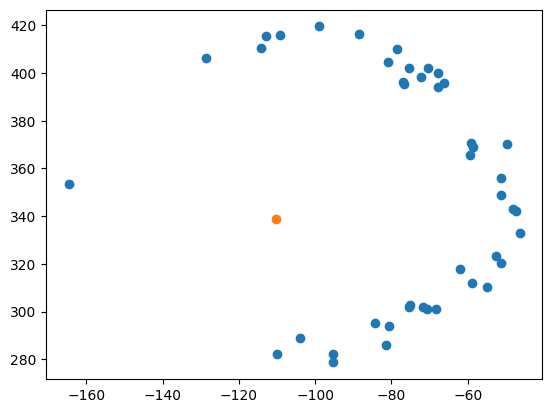

In [26]:
num = 23 #TODO: check weird events such as 23
# plt.scatter(rotate_event(coordinates[0], main_angles[0])[:,0], rotate_event(coordinates[0], main_angles[0])[:,2])
plt.scatter(coordinates[num][0], coordinates[num][2])
plt.scatter(intersections[num][0], intersections[num][2])
plt.show()

In [ ]:
plot_event(coordinates[num], drift_chamber_coordinates[num],tpc_coordinates[num] , transposed=True)

In [27]:
rotate_events(coordinates, main_angles)

In [28]:
# plot_cyl(file, coordinates)

In [29]:
move_events_to_grid(coordinates, grid)

In [30]:
# plot_cyl(file, coordinates, True)

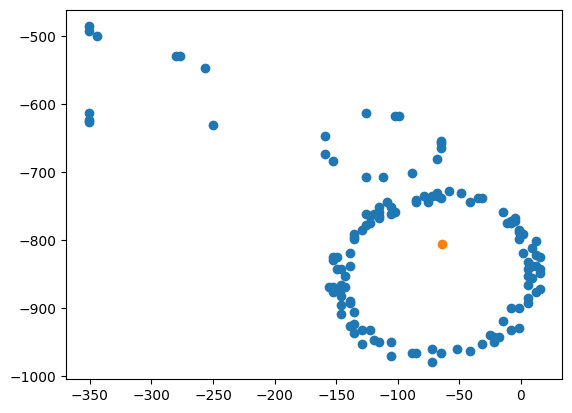

In [61]:
num = 7 #TODO: check weird events such as 23
# plt.scatter(rotate_event(coordinates[0], main_angles[0])[:,0], rotate_event(coordinates[0], main_angles[0])[:,2])
plt.scatter(coordinates[num][0], coordinates[num][2])
plt.scatter(intersections[num][0], intersections[num][2])
plt.show()

In [32]:
r_c = (coordinates[:,0] - intersections[:,0]) ** 2 + (coordinates[:,1] - intersections[:,1]) ** 2

In [57]:
intersections

array([[  71.23919376, 1000.        ,  102.37970941],
       [  78.81067967, 1000.        , -481.82736205],
       [ -40.72113419, 1000.        ,  952.20277949],
       ...,
       [ -55.60532184, 1000.        ,  316.76454642],
       [  94.95861688, 1000.        , -112.93448657],
       [ -56.77124499, 1000.        ,  699.75050333]])

In [41]:
coordinates[1][0].shape

(90,)

In [43]:
repeat_nums = np.array([coord[0].shape[0] for coord in coordinates])

In [51]:
np.repeat(intersections[:,0], repeat_nums, axis=0).shape[0]

87038

In [87]:
edf = pd.DataFrame(coordinates, columns=['x_c', 'y_c', 'z_c', 'wv_c'])
edf['r_c'] = r_c
edf

,x_c,y_c,z_c,wv_c,r_c
0,"[32.32013058436115, 72.64013058436132, 133.12013058436156, 129.76013058436155, 22.24013058436111, 133.12013058436156, 123.04013058436152, 106.24013058436145, 133.12013058436156, 123.04013058436152, 12.16013058436107, 69.2801305843613, 92.8001305843614, 126.40013058436153, 8.800130584361057, 119.6801305843615, 126.40013058436153, 12.16013058436107, 89.44013058436138, 129.76013058436155, 59.20013058436126, 62.560130584361275, 116.3201305843615, 112.96013058436148, 102.88013058436144, 102.88013058436144, 106.24013058436145, 86.08013058436137, 45.76013058436121, 112.96013058436148, 8.800130584361057, 126.40013058436153, 123.04013058436152, 12.16013058436107, 52.480130584361234, 39.04013058436118, 65.92013058436129, 109.60013058436147, 72.64013058436132, 12.16013058436107, 12.16013058436107, 99.52013058436143, 129.76013058436155, 49.12013058436122, 129.76013058436155, 119.6801305843615, 133.12013058436156, 35.680130584361166, 35.680130584361166, 32.32013058436115, 18.880130584361098, 99.52013058436143, 35.680130584361166, 18.880130584361098, 15.520130584361084, 55.84013058436125, 89.44013058436138, 15.520130584361084, 76.00013058436133, 119.6801305843615, 72.64013058436132, 59.20013058436126, 45.76013058436121, 39.04013058436118, 15.520130584361084, 126.40013058436153, 69.2801305843613, 45.76013058436121, 35.680130584361166, 15.520130584361084, 39.04013058436118, 112.96013058436148, 109.60013058436147, 32.32013058436115, 25.600130584361125, 42.40013058436119, 119.6801305843615, 109.60013058436147, 126.40013058436153, 22.24013058436111, 18.880130584361098, 18.880130584361098, 102.88013058436144, 28.96013058436114, 129.76013058436155, 112.96013058436148, 42.40013058436119, 18.880130584361098, 82.72013058436136, 112.96013058436148, 123.04013058436152, 116.3201305843615, 49.12013058436122, 55.84013058436125]","[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]","[155.67999999995368, 44.79999999995698, 125.43999999995458, 135.51999999995428, 148.95999999995388, 98.55999999995538, 138.87999999995418, 159.03999999995358, 122.07999999995468, 142.23999999995408, 108.63999999995508, 169.11999999995328, 48.15999999995688, 138.87999999995418, 98.55999999995538, 64.95999999995638, 132.15999999995438, 88.47999999995568, 169.11999999995328, 101.91999999995528, 169.11999999995328, 44.79999999995698, 148.95999999995388, 58.23999999995658, 51.51999999995678, 54.87999999995668, 58.23999999995658, 169.11999999995328, 165.75999999995338, 155.67999999995368, 101.91999999995528, 75.03999999995608, 81.75999999995588, 125.43999999995458, 165.75999999995338, 58.23999999995658, 165.75999999995338, 58.23999999995658, 169.11999999995328, 111.99999999995498, 115.35999999995488, 54.87999999995668, 91.83999999995558, 165.75999999995338, 88.47999999995568, 71.67999999995618, 111.99999999995498, 64.95999999995638, 61.59999999995648, 68.31999999995628, 122.07999999995468, 155.67999999995368, 145.59999999995398, 85.11999999995578, 98.55999999995538, 162.39999999995348, 51.51999999995678, 111.99999999995498, 48.15999999995688, 81.75999999995588, 162.39999999995348, 51.51999999995678, 54.87999999995668, 61.59999999995648, 118.71999999995478, 115.35999999995488, 165.75999999995338, 155.67999999995368, 148.95999999995388, 85.11999999995578, 148.9599999999538

In [88]:
unraveled_data = {col: [] for col in edf.columns}
row_indices = []

# Iterate over the DataFrame and unravel the arrays
for i, row in edf.iterrows():
    max_length = max(len(row[col]) for col in edf.columns)
    for k in range(max_length):
        row_indices.append((i, k))
        for col in edf.columns:
            if k < len(row[col]):
                unraveled_data[col].append(row[col][k])
            else:
                unraveled_data[col].append(np.nan)  # Handle cases where arrays are of different lengths

# Create a new DataFrame from the unraveled data
unraveled_df = pd.DataFrame(unraveled_data)

# Create a MultiIndex for the rows
multi_index = pd.MultiIndex.from_tuples(row_indices, names=['entry', 'subentry'])
unraveled_df.index = multi_index


In [89]:
unraveled_df['r_c'] = np.sqrt(unraveled_df.r_c)

In [90]:
edf = unraveled_df

In [91]:
edf['x_i'] = np.repeat(intersections[:,0], repeat_nums, axis=0)
edf['z_i'] = np.repeat(intersections[:,2], repeat_nums, axis=0)

In [92]:
edf

x_c     y_c     z_c        wv_c        r_c        x_i  \
entry subentry                                                                 
0     0          32.320131  1000.0  155.68  414.960630  38.919063  71.239194   
      1          72.640131  1000.0   44.80  359.842520   1.400937  71.239194   
      2         133.120131  1000.0  125.44  651.968504  61.880937  71.239194   
      3         129.760131  1000.0  135.52  365.354331  58.520937  71.239194   
      4          22.240131  1000.0  148.96  354.330709  48.999063  71.239194   
...                    ...     ...     ...         ...        ...        ...   
981   83       -112.159869  1000.0  790.72  596.850394  55.388624 -56.771245   
      84        -98.719869  1000.0  656.32  464.566929  41.948624 -56.771245   
      85          8.800131  1000.0  753.76  486.614173  65.571376 -56.771245   
      86        -14.719869  1000.0  800.80  475.590551  42.051376 -56.771245   
      87        -44.959869  1000.0  639.52  618.897638  11.811376 -56.771245   

                       z_i  
entry subentry              
0     0         102.379709  
      1         102.379709  
      2         102.379709  
      3         102.379709  
      4         102.379709  
...                    ...  
981   83        699.750503  
      84        699.750503  
      85        699.750503  
      86        699.750503  
      87        699.750503  

[87038 rows x 7 columns]

In [93]:
edf[edf.r_c>200]

x_c     y_c      z_c        wv_c         r_c  \
entry subentry                                                        
7     64       -350.719869  1000.0  -627.20  387.401575  286.364259   
      65       -350.719869  1000.0  -492.80  442.519685  286.364259   
      66       -350.719869  1000.0  -623.84  348.818898  286.364259   
      67       -343.999869  1000.0  -499.52  552.755906  279.644259   
      68       -276.799869  1000.0  -529.76  392.913386  212.444259   
...                    ...     ...      ...         ...         ...   
973   17       -350.719869  1000.0   854.56  337.795276  242.186431   
      18       -350.719869  1000.0   992.32  354.330709  242.186431   
      19       -350.719869  1000.0  1160.32  453.543307  242.186431   
      20       -350.719869  1000.0   841.12  315.748031  242.186431   
      21       -350.719869  1000.0   888.16  530.708661  242.186431   

                       x_i         z_i  
entry subentry                          
7     64        -64.355610 -805.876047  
      65        -64.355610 -805.876047  
      66        -64.355610 -805.876047  
      67        -64.355610 -805.876047  
      68        -64.355610 -805.876047  
...                    ...         ...  
973   17       -108.533439  751.676763  
      18       -108.533439  751.676763  
      19       -108.533439  751.676763  
      20       -108.533439  751.676763  
      21       -108.533439  751.676763  

[1541 rows x 7 columns]

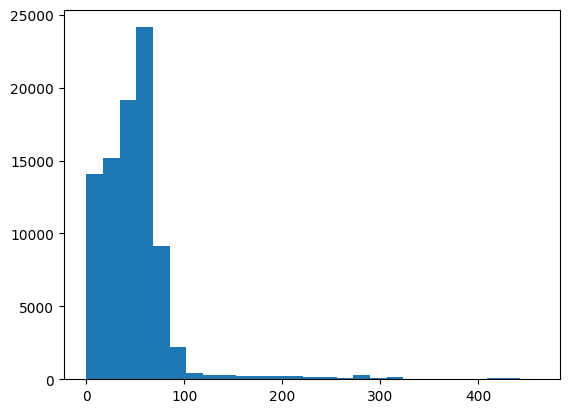

In [94]:
plt.hist(edf[edf.r_c<1000].r_c, bins='doane')
plt.show()

In [95]:
def edf_to_bdf(edf_col: pd.Series, bdf: pd.DataFrame):
  to_bdf = [sub.iloc[0] for _, sub in edf_col.groupby(level=0)]
  bdf[edf_col.name] = pd.Series(to_bdf)

In [96]:
bdf = pd.DataFrame()

In [97]:
edf_to_bdf(edf.r_c.groupby(level=0).transform('mean'), bdf)

In [98]:
bdf.isna().sum()

r_c    0
dtype: int64

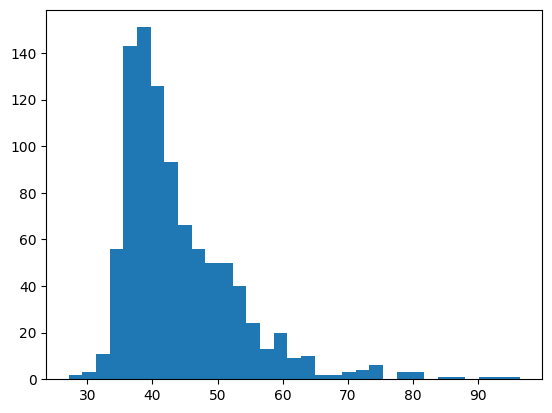

In [99]:
plt.hist(bdf[bdf.r_c<100].r_c, bins='auto')
plt.show()

In [100]:
edf['t_c'] = np.zeros(edf.shape[0])

In [101]:
edf.drop('y_c', axis=1, inplace=True)

In [102]:
edf.rename(columns={'z_c': 'y_c', 'z_i': 'y_i'}, inplace=True)

In [103]:
edf

x_c     y_c        wv_c        r_c        x_i  \
entry subentry                                                         
0     0          32.320131  155.68  414.960630  38.919063  71.239194   
      1          72.640131   44.80  359.842520   1.400937  71.239194   
      2         133.120131  125.44  651.968504  61.880937  71.239194   
      3         129.760131  135.52  365.354331  58.520937  71.239194   
      4          22.240131  148.96  354.330709  48.999063  71.239194   
...                    ...     ...         ...        ...        ...   
981   83       -112.159869  790.72  596.850394  55.388624 -56.771245   
      84        -98.719869  656.32  464.566929  41.948624 -56.771245   
      85          8.800131  753.76  486.614173  65.571376 -56.771245   
      86        -14.719869  800.80  475.590551  42.051376 -56.771245   
      87        -44.959869  639.52  618.897638  11.811376 -56.771245   

                       y_i  t_c  
entry subentry                   
0     0         102.379709  0.0  
      1         102.379709  0.0  
      2         102.379709  0.0  
      3         102.379709  0.0  
      4         102.379709  0.0  
...                    ...  ...  
981   83        699.750503  0.0  
      84        699.750503  0.0  
      85        699.750503  0.0  
      86        699.750503  0.0  
      87        699.750503  0.0  

[87038 rows x 7 columns]

In [104]:
def applySpaceCut(edf: pd.DataFrame) -> pd.DataFrame:
    return edf[(abs(edf['x_c'] - edf['x_i']) <= 220) & (abs(edf['y_c'] - edf['y_i']) <= 220)]

In [105]:
edf.shape[0]

87038

In [106]:
edf['z_c'] = np.zeros(edf.shape[0]) + 2000

In [124]:
edf['nx_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,0], repeat_nums, axis=0)
edf['ny_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,2], repeat_nums, axis=0)
edf['nz_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,1], repeat_nums, axis=0)

C:\Users\BRINE\AppData\Local\Temp\ipykernel_10484\3569810111.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edf['nx_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
C:\Users\BRINE\AppData\Local\Temp\ipykernel_10484\3569810111.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edf['ny_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
C:\Users\BRINE\AppData\Local\Temp\ipykernel_10484\3569810111.py:5: DeprecationWa

In [120]:
true_direction_coordinates

array([array([0.10603718]), array([1.48846692]), array([0.15238881])],
      dtype=object)

In [123]:
(true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')

C:\Users\BRINE\AppData\Local\Temp\ipykernel_10484\211402523.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')


array([[ 0.07069146,  0.99231128,  0.10159254],
       [ 0.07082068,  0.89861779, -0.43297864],
       [-0.02947753,  0.72388766,  0.68928784],
       ...,
       [-0.05293509,  0.95197878,  0.30155313],
       [ 0.09394151,  0.98928891, -0.11172484],
       [-0.04646403,  0.81844304,  0.57270593]])

In [111]:
true_direction_coordinates.astype('float')

C:\Users\BRINE\AppData\Local\Temp\ipykernel_10484\1031081582.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_direction_coordinates.astype('float')


array([[ 0.10603718,  1.48846692,  0.15238881],
       [ 0.10623102,  1.34792666, -0.64946795],
       [-0.04421629,  1.08583146,  1.03393173],
       ...,
       [-0.07940263,  1.42796819,  0.4523297 ],
       [ 0.14091226,  1.48393335, -0.16758725],
       [-0.06969605,  1.22766459,  0.85905892]])

In [125]:
edf

x_c     y_c        wv_c        r_c        x_i  \
entry subentry                                                         
0     0          32.320131  155.68  414.960630  38.919063  71.239194   
      1          72.640131   44.80  359.842520   1.400937  71.239194   
      2         133.120131  125.44  651.968504  61.880937  71.239194   
      3         129.760131  135.52  365.354331  58.520937  71.239194   
      4          22.240131  148.96  354.330709  48.999063  71.239194   
...                    ...     ...         ...        ...        ...   
981   83       -112.159869  790.72  596.850394  55.388624 -56.771245   
      84        -98.719869  656.32  464.566929  41.948624 -56.771245   
      85          8.800131  753.76  486.614173  65.571376 -56.771245   
      86        -14.719869  800.80  475.590551  42.051376 -56.771245   
      87        -44.959869  639.52  618.897638  11.811376 -56.771245   

                       y_i  t_c     z_c      nx_p      ny_p      nz_p  
entry subentry                                                         
0     0         102.379709  0.0  2000.0  0.070691  0.101593  0.992311  
      1         102.379709  0.0  2000.0  0.070691  0.101593  0.992311  
      2         102.379709  0.0  2000.0  0.070691  0.101593  0.992311  
      3         102.379709  0.0  2000.0  0.070691  0.101593  0.992311  
      4         102.379709  0.0  2000.0  0.070691  0.101593  0.992311  
...                    ...  ...     ...       ...       ...       ...  
981   83        699.750503  0.0  2000.0 -0.046464  0.572706  0.818443  
      84        699.750503  0.0  2000.0 -0.046464  0.572706  0.818443  
      85        699.750503  0.0  2000.0 -0.046464  0.572706  0.818443  
      86        699.750503  0.0  2000.0 -0.046464  0.572706  0.818443  
      87        699.750503  0.0  2000.0 -0.046464  0.572706  0.818443  

[87038 rows x 11 columns]

In [135]:
idf = pd.DataFrame()
idf['W'] = [35.]
idf['zdis'] = [800.]

In [136]:
idf

,W,zdis
0,35.0,800.0


In [128]:
edf = applySpaceCut(edf)

In [138]:
planeRecalculation(edf, idf)

C:\Users\BRINE\AppData\Local\Temp\ipykernel_10484\2835767579.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha = (float(dist)) / N[:,2]
C:\Users\BRINE\AppData\Local\Temp\ipykernel_10484\2835767579.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['t_c'] = edf['t_c'] + np.sign(R_new[:,2] - R[:,2]) * t_dif
C:\Users\BRINE\AppData\Local\Temp\ipykernel_10484\2835767579.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [139]:
edf

x_c     y_c        wv_c        r_c        x_i  \
entry subentry                                                         
0     0          32.320131  155.68  414.960630  38.919063  71.239194   
      1          72.640131   44.80  359.842520   1.400937  71.239194   
      2         133.120131  125.44  651.968504  61.880937  71.239194   
      3         129.760131  135.52  365.354331  58.520937  71.239194   
      4          22.240131  148.96  354.330709  48.999063  71.239194   
...                    ...     ...         ...        ...        ...   
981   83       -112.159869  790.72  596.850394  55.388624 -56.771245   
      84        -98.719869  656.32  464.566929  41.948624 -56.771245   
      85          8.800131  753.76  486.614173  65.571376 -56.771245   
      86        -14.719869  800.80  475.590551  42.051376 -56.771245   
      87        -44.959869  639.52  618.897638  11.811376 -56.771245   

                       y_i       t_c     z_c      nx_p      ny_p      nz_p  \
entry subentry                                                               
0     0         102.379709 -0.008931  2000.0  0.070691  0.101593  0.992311   
      1         102.379709  0.019391  2000.0  0.070691  0.101593  0.992311   
      2         102.379709 -0.022457  2000.0  0.070691  0.101593  0.992311   
      3         102.379709 -0.025073  2000.0  0.070691  0.101593  0.992311   
      4         102.379709 -0.004257  2000.0  0.070691  0.101593  0.992311   
...                    ...       ...     ...       ...       ...       ...   
981   83        699.750503 -0.200377  2000.0 -0.046464  0.572706  0.818443   
      84        699.750503  0.089090  2000.0 -0.046464  0.572706  0.818443   
      85        699.750503 -0.104178  2000.0 -0.046464  0.572706  0.818443   
      86        699.750503 -0.204793  2000.0 -0.046464  0.572706  0.818443   
      87        699.750503  0.137571  2000.0 -0.046464  0.572706  0.818443   

                recalculated_x  recalculated_y  recalculated_z  
entry subentry                                                  
0     0              32.378691      155.517353     1997.328174  
      1              72.710889       44.608904     2005.809716  
      2             132.694921      125.202958     1993.285306  
      3             129.306747      135.191481     1992.504055  
      4              22.278907      148.889697     1998.726212  
...                        ...             ...             ...  
981   83           -108.880357      779.812763     1941.018094  
      84            -99.897214      658.216783     2026.614927  
      85              7.360383      749.021378     1969.163513  
      86            -16.334739      789.143311     1939.742969  
      87            -44.909357      641.869502     2041.175674  

[84411 rows x 14 columns]

In [143]:
edf['x_p'] = np.zeros(edf.shape[0])
edf['y_p'] = np.zeros(edf.shape[0])
edf['z_p'] = np.zeros(edf.shape[0])


C:\Users\BRINE\AppData\Local\Temp\ipykernel_10484\210028248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['x_p'] = np.zeros(edf.shape[0])
C:\Users\BRINE\AppData\Local\Temp\ipykernel_10484\210028248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['y_p'] = np.zeros(edf.shape[0])
C:\Users\BRINE\AppData\Local\Temp\ipykernel_10484\210028248.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [144]:
edf

x_c     y_c        wv_c        r_c        x_i  \
entry subentry                                                         
0     0          32.320131  155.68  414.960630  38.919063  71.239194   
      1          72.640131   44.80  359.842520   1.400937  71.239194   
      2         133.120131  125.44  651.968504  61.880937  71.239194   
      3         129.760131  135.52  365.354331  58.520937  71.239194   
      4          22.240131  148.96  354.330709  48.999063  71.239194   
...                    ...     ...         ...        ...        ...   
981   83       -112.159869  790.72  596.850394  55.388624 -56.771245   
      84        -98.719869  656.32  464.566929  41.948624 -56.771245   
      85          8.800131  753.76  486.614173  65.571376 -56.771245   
      86        -14.719869  800.80  475.590551  42.051376 -56.771245   
      87        -44.959869  639.52  618.897638  11.811376 -56.771245   

                       y_i       t_c     z_c      nx_p      ny_p      nz_p  \
entry subentry                                                               
0     0         102.379709 -0.008931  2000.0  0.070691  0.101593  0.992311   
      1         102.379709  0.019391  2000.0  0.070691  0.101593  0.992311   
      2         102.379709 -0.022457  2000.0  0.070691  0.101593  0.992311   
      3         102.379709 -0.025073  2000.0  0.070691  0.101593  0.992311   
      4         102.379709 -0.004257  2000.0  0.070691  0.101593  0.992311   
...                    ...       ...     ...       ...       ...       ...   
981   83        699.750503 -0.200377  2000.0 -0.046464  0.572706  0.818443   
      84        699.750503  0.089090  2000.0 -0.046464  0.572706  0.818443   
      85        699.750503 -0.104178  2000.0 -0.046464  0.572706  0.818443   
      86        699.750503 -0.204793  2000.0 -0.046464  0.572706  0.818443   
      87        699.750503  0.137571  2000.0 -0.046464  0.572706  0.818443   

                recalculated_x  recalculated_y  recalculated_z  x_p  y_p  z_p  
entry subentry                                                                 
0     0              32.378691      155.517353     1997.328174  0.0  0.0  0.0  
      1              72.710889       44.608904     2005.809716  0.0  0.0  0.0  
      2             132.694921      125.202958     1993.285306  0.0  0.0  0.0  
      3             129.306747      135.191481     1992.504055  0.0  0.0  0.0  
      4              22.278907      148.889697     1998.726212  0.0  0.0  0.0  
...                        ...             ...             ...  ...  ...  ...  
981   83           -108.880357      779.812763     1941.018094  0.0  0.0  0.0  
      84            -99.897214      658.216783     2026.614927  0.0  0.0  0.0  
      85              7.360383      749.021378     1969.163513  0.0  0.0  0.0  
      86            -16.334739      789.143311     1939.742969  0.0  0.0  0.0  
      87            -44.909357      641.869502     2041.175674  0.0  0.0  0.0  

[84411 rows x 17 columns]

In [169]:
planeRotation(edf)

C:\Users\BRINE\AppData\Local\Temp\ipykernel_10484\4257877780.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['rotated_x'] = rotated_R[:,0]
C:\Users\BRINE\AppData\Local\Temp\ipykernel_10484\4257877780.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['rotated_y'] = rotated_R[:,1]
C:\Users\BRINE\AppData\Local\Temp\ipykernel_10484\4257877780.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [149]:
edf.loc[0]

,x_c,y_c,wv_c,r_c,x_i,y_i,t_c,z_c,nx_p,ny_p,...,z_p,rotated_x,rotated_y,rotated_z,rotated_x_i,rotated_y_i,rotated_z_i,rotated_nx_p,rotated_ny_p,rotated_nz_p
subentry,,,,,,,,,,,,,,,,,,,,,
0,32.320131,155.68,414.960630,38.919063,71.239194,102.379709,-0.008931,2000.0,0.070691,0.101593,...,0.0,-109.457156,-48.318654,2000.059574,-70.691455,-101.59254,2000.059574,-0.035277,-0.050698,0.998091
1,72.640131,44.80,359.842520,1.400937,71.239194,102.379709,0.019391,2000.0,0.070691,0.101593,...,0.0,-69.425901,-159.659597,2000.059574,-70.691455,-101.59254,2000.059574,-0.035277,-0.050698,0.998091
2,133.120131,125.44,651.968504,61.880937,71.239194,102.379709,-0.022457,2000.0,0.070691,0.101593,...,0.0,-8.997477,-78.426894,2000.059574,-70.691455,-101.59254,2000.059574,-0.035277,-0.050698,0.998091
3,129.760131,135.52,365.354331,58.520937,71.239194,102.379709,-0.025073,2000.0,0.070691,0.101593,...,0.0,-12.357930,-68.398534,2000.059574,-70.691455,-101.59254,2000.059574,-0.035277,-0.050698,0.998091
4,22.240131,148.96,354.330709,48.999063,71.239194,102.379709,-0.004257,2000.0,0.070691,0.101593,...,0.0,-119.606545,-55.017599,2000.059574,-70.691455,-101.59254,2000.059574,-0.035277,-0.050698,0.998091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,112.960131,75.04,392.913386,41.720937,71.239194,102.379709,-0.000577,2000.0,0.070691,0.101593,...,0.0,-28.972383,-128.922180,2000.059574,-70.691455,-101.59254,2000.059574,-0.035277,-0.050698,0.998091
90,123.040131,95.20,536.220472,51.800937,71.239194,102.379709,-0.009825,2000.0,0.070691,0.101593,...,0.0,-18.947331,-108.650903,2000.059574,-70.691455,-101.59254,2000.059574,-0.035277,-0.050698,0.998091
91,116.320131,135.52,453.543307,45.080937,71.239194,102.379709,-0.021903,2000.0,0.070691,0.101593,...,0.0,-25.699862,-68.405297,2000.059574,-70.691455,-101.59254,2000.059574,-0.035277,-0.050698,0.998091


In [170]:
edf_c = applySecondSpaceCut(edf)

In [171]:
edf_c.loc[5]

,x_c,y_c,wv_c,r_c,x_i,y_i,t_c,z_c,nx_p,ny_p,...,z_p,rotated_x,rotated_y,rotated_z,rotated_x_i,rotated_y_i,rotated_z_i,rotated_nx_p,rotated_ny_p,rotated_nz_p
subentry,,,,,,,,,,,,,,,,,,,,,
0,-28.159869,-818.72,525.196850,74.84478,46.684911,-740.803727,-0.162769,2000.0,0.037486,-0.594842,...,0.0,-108.644853,509.747350,2048.347526,-37.486499,594.841842,2048.347526,-0.017572,0.278836,0.960178
1,-34.879869,-791.84,448.031496,81.56478,46.684911,-740.803727,-0.103272,2000.0,0.037486,-0.594842,...,0.0,-116.530917,538.541796,2048.347526,-37.486499,594.841842,2048.347526,-0.017572,0.278836,0.960178
2,-7.999869,-869.12,414.960630,54.68478,46.684911,-740.803727,-0.271959,2000.0,0.037486,-0.594842,...,0.0,-87.413388,458.010434,2048.347526,-37.486499,594.841842,2048.347526,-0.017572,0.278836,0.960178
3,-18.079869,-707.84,464.566929,64.76478,46.684911,-740.803727,0.086629,2000.0,0.037486,-0.594842,...,0.0,-104.017956,634.098089,2048.347526,-37.486499,594.841842,2048.347526,-0.017572,0.278836,0.960178
4,35.680131,-670.88,321.259843,11.00478,46.684911,-740.803727,0.167915,2000.0,0.037486,-0.594842,...,0.0,-49.641945,678.574076,2048.347526,-37.486499,594.841842,2048.347526,-0.017572,0.278836,0.960178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,106.240131,-842.24,343.307087,59.55522,46.684911,-740.803727,-0.230686,2000.0,0.037486,-0.594842,...,0.0,19.578683,484.616603,2048.347526,-37.486499,594.841842,2048.347526,-0.017572,0.278836,0.960178
97,72.640131,-691.04,514.173228,25.95522,46.684911,-740.803727,0.113081,2000.0,0.037486,-0.594842,...,0.0,-11.248623,653.314626,2048.347526,-37.486499,594.841842,2048.347526,-0.017572,0.278836,0.960178
98,22.240131,-869.12,409.448819,24.44478,46.684911,-740.803727,-0.275650,2000.0,0.037486,-0.594842,...,0.0,-59.168245,457.889344,2048.347526,-37.486499,594.841842,2048.347526,-0.017572,0.278836,0.960178


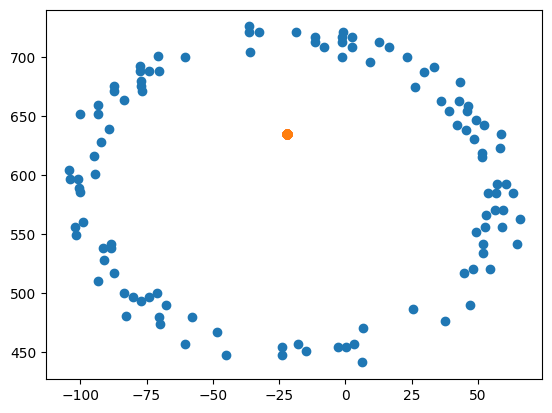

In [187]:
num = 15
event = edf_c.loc[num]
plt.scatter(event.rotated_x, event.rotated_y)
plt.scatter(event.rotated_x_i, event.rotated_y_i)
plt.show()

primary particle - last with wv = 0

In [24]:
# coordinates[:,3]
lambdas = np.concatenate(coordinates[:,3])

In [25]:
lambdas.shape

(86682,)

In [26]:
lambdas.shape[0] / coordinates.shape[0]

88.09146341463415

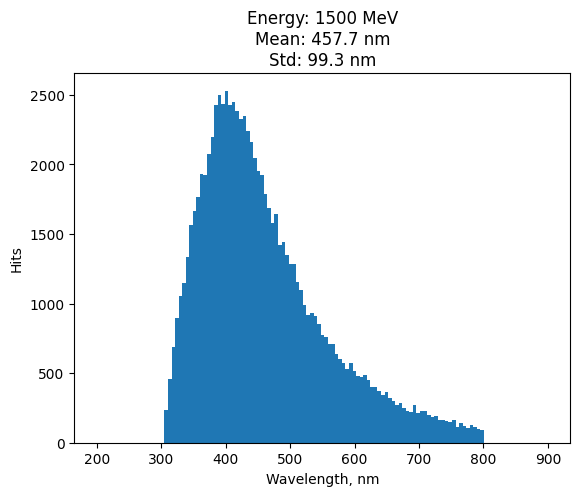

In [27]:
plt.hist(lambdas, bins=PDE_wvs)
plt.xlabel('Wavelength, nm')
plt.title(f'Energy: 1500 MeV\nMean: {round(lambdas.mean(), 1)} nm' + '\n' + f'Std: {round(lambdas.std(), 1)} nm')
plt.ylabel('Hits')
# plt.xlim((200, 900))
plt.show()

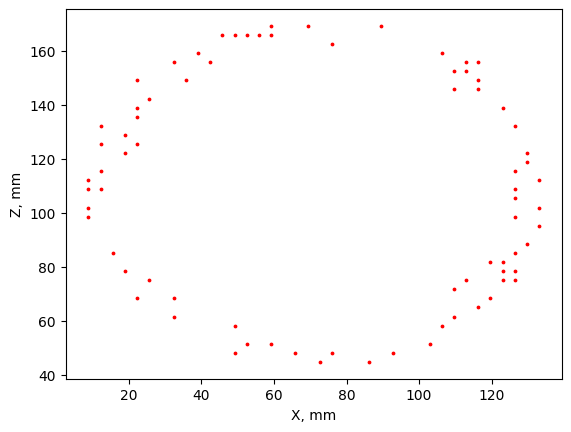

In [28]:
# delta_r = np.sqrt(x ** 2 + y ** 2 - 1000 ** 2)
plt.scatter(coordinates[0][0], coordinates[0][2], c='red', s=3)
# plt.plot(1000 * np.cos(np.linspace(0, 2*np.pi,1000)), 1000 * np.sin(np.linspace(0, 2*np.pi,1000)))
# plt.xlim((-160, 50))
# plt.ylim((-1100, -650))
plt.xlabel('X, mm')
plt.ylabel('Z, mm')
# plt.title('p = 1500 MeV' + f'\n{coordinates[0][0].shape[0]} Hits')
plt.show()

In [29]:
print(coordinates[0][0].shape)

(77,)


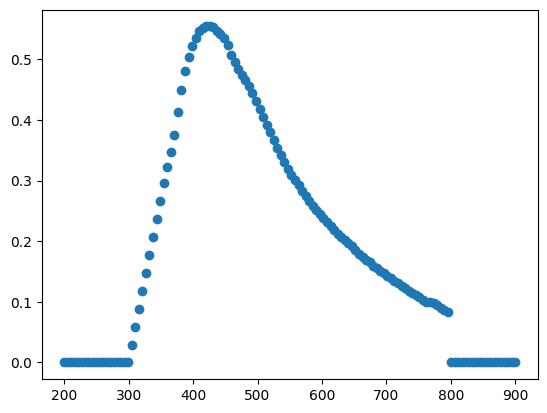

In [30]:
plt.scatter(PDE_wvs, PDEs)
plt.show()

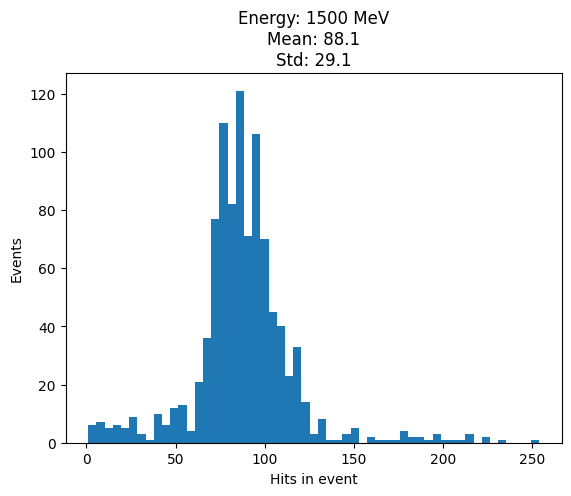

In [31]:
events_len = []
for i in range(coordinates.shape[0]):
    events_len.append(len(coordinates[i][0]))
events_len = np.array(events_len)
plt.hist(events_len, bins='auto')
plt.xlabel('Hits in event')
plt.title(f'Energy: 1500 MeV\nMean: {round(events_len.mean(), 1)}' + '\n' + f'Std: {round(events_len.std(), 1)}')
plt.ylabel('Events')
plt.show()

# End of main

In [89]:
coordinates[0]

array([array([ 34.80013058, 123.28013058,  34.80013058,  69.56013058,
              113.80013058,  12.68013058, 132.76013058, 126.44013058,
              132.76013058, 129.60013058, 132.76013058, 126.44013058,
               41.12013058, 132.76013058, 113.80013058, 110.64013058,
              132.76013058, 123.28013058,  56.92013058,  85.36013058,
               94.84013058,  82.20013058,  63.24013058,   9.52013058,
              126.44013058, 126.44013058,  12.68013058, 120.12013058,
              126.44013058, 120.12013058,  72.72013058, 116.96013058,
               60.08013058, 123.28013058,  63.24013058, 113.80013058,
              104.32013058,  82.20013058,  72.72013058,  22.16013058,
              123.28013058, 132.76013058,  41.12013058,  28.48013058,
               85.36013058, 132.76013058, 116.96013058,  50.60013058,
                9.52013058, 123.28013058, 129.60013058,  53.76013058,
               12.68013058,  15.84013058, 116.96013058,  66.40013058,
                6.36

In [46]:
lambdas = 1239.841 / np.array(file['events;2']['FarichBarrelG4Hits.energy'].array()) * 1e-9

In [47]:
lambdas = np.concatenate(lambdas)

In [48]:
lambdas = lambdas[lambdas > 150]

In [42]:
mask = (lambdas >= 380) & (lambdas <= 780)

In [43]:
lambdas[mask].shape[0] / lambdas.shape[0]

0.3333763414745215

In [52]:
lambdas.shape[0]

527032

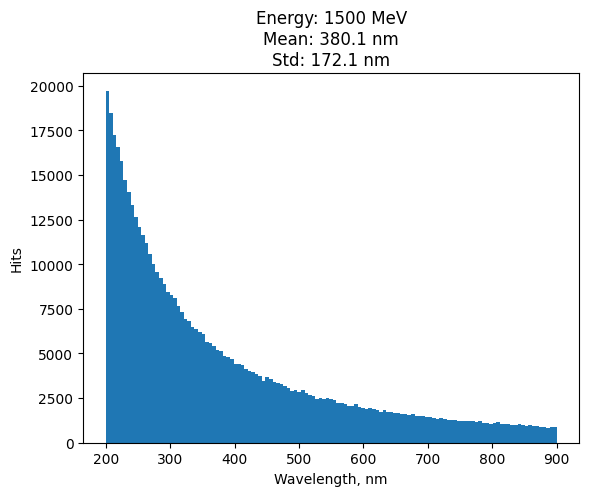

In [46]:
plt.hist(lambdas, bins='auto')
plt.xlabel('Wavelength, nm')
plt.title(f'Energy: 1500 MeV\nMean: {round(lambdas.mean(), 1)} nm' + '\n' + f'Std: {round(lambdas.std(), 1)} nm')
plt.ylabel('Hits')
plt.show()

In [47]:
cut_shapes = np.zeros(1000)
for num in range(1000):
    # arr = 1239.841 / np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9
    # mask = (arr >= 350) & (arr <= 800)
    # cut_shapes[num] = arr[mask].shape[0]
    cut_shapes[num] = np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num].shape[0]

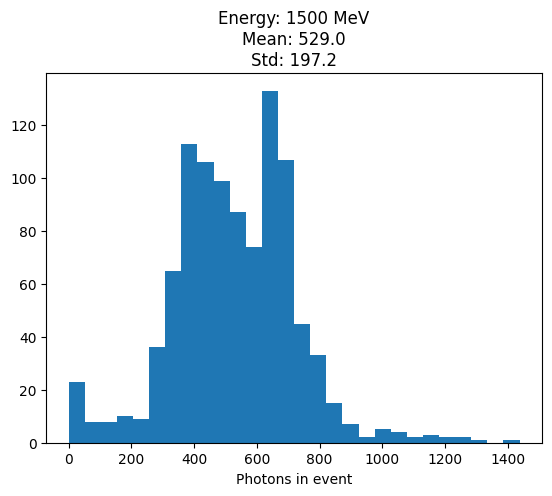

In [48]:
plt.hist(cut_shapes, bins='auto')
plt.title(f'Energy: 1500 MeV\nMean: {round(cut_shapes.mean(), 1)}' + '\n' + f'Std: {round(cut_shapes.std(), 1)}')
plt.xlabel('Photons in event')
plt.show()

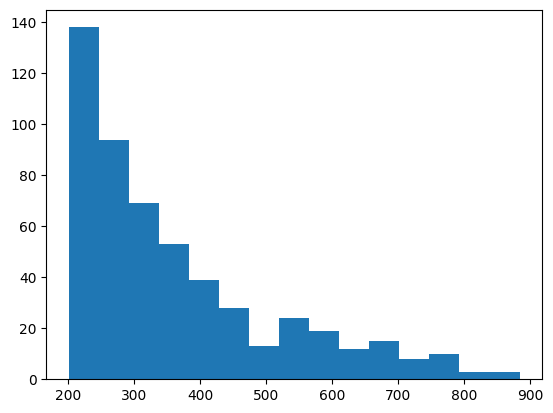

In [49]:
num = 5
plt.hist(1239.841 / (1 * (np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num][np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num] < 1e-8] * 1e9)), bins='auto')
plt.show()

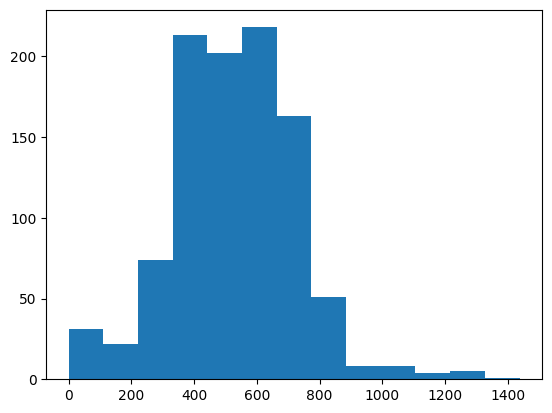

In [50]:
plt.hist([np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[i].shape[0] for i in range(1000)], bins='doane')
plt.show()

In [51]:
minn = 1
for i in range(1000):
    try:
        tmp  = min(np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[i])
    except ValueError:
        pass
    minn = min(minn, tmp)
print(minn)

1.3776198951913162e-09


In [53]:
pdes_tmp = pd.read_csv('PDE.csv', sep=';', names=['A'])
t1 = []
t2 = []
for inedx, row in pdes_tmp.iterrows():
    t1.append(float(row['A'].split(';')[0].replace(',', '.')))
    t2.append(float(row['A'].split(';')[1].replace(',', '.')))

In [54]:
t1 = np.array(t1)
t2 = np.array(t2)

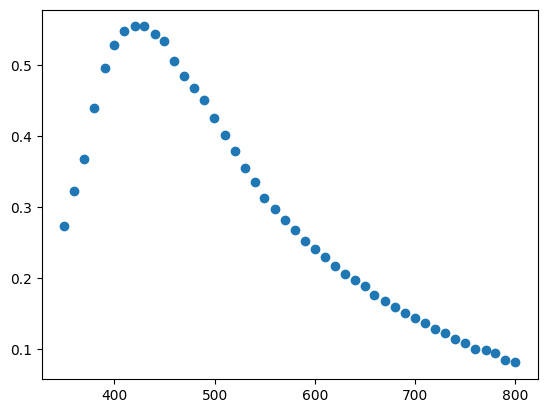

In [56]:
plt.scatter(t1, t2)
plt.show()

In [65]:
t1.shape

(46,)

In [51]:
a1, a2_ = np.histogram(lambdas, bins=128)

In [67]:
PDE_wvs = (PDE_wvs[1:] + PDE_wvs[:-1]) / 2

In [54]:
PDE_wvs.shape

(128,)

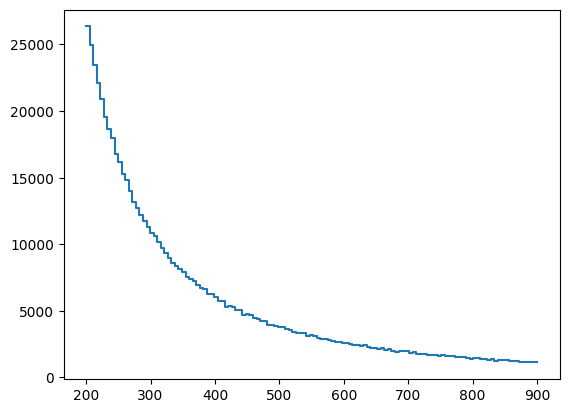

In [53]:
plt.step(PDE_wvs, a1, where='post')
plt.show()

In [70]:
a1.shape

(127,)

In [71]:
a1.sum()

527032

In [72]:
# conv_x = np.arange(min(t1.min(), a2.min()), max(t1.max(), a2.max()) + 1)


In [158]:
PDEs = np.interp(PDE_wvs, t1, t2, left=0, right=0)
# dist1_interpolated = dist1_interpolated / dist1_interpolated.sum()
# dist2_interpolated = np.interp(conv_x, a2, a1 / a1.sum(), left=0, right=0)

# Perform convolution
convolution_result = np.convolve(PDEs, a1, mode='same')


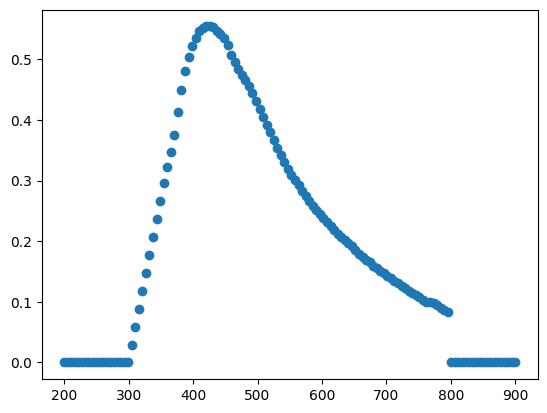

In [68]:
plt.scatter(PDE_wvs, PDEs)
plt.show()

In [149]:
PDEs.sum()

1.0

In [86]:
dist2_interpolated.shape[0]

696

In [79]:
convolution_result.sum()

9008943.822588062

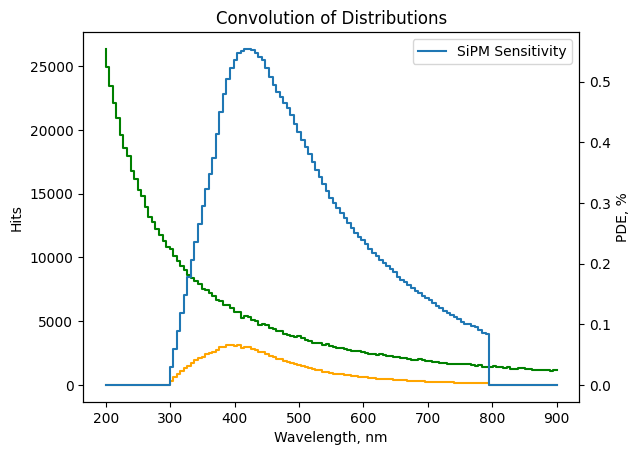

In [72]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax2.step(PDE_wvs, PDEs, label='SiPM Sensitivity')
ax1.step(PDE_wvs, a1, label='Original Distribution', c='g')
ax1.step(PDE_wvs, a1 * PDEs, label='Convolution', c='orange')

ax1.set_title('Convolution of Distributions')
ax1.set_xlabel('Wavelength, nm')
ax1.set_ylabel('Hits')
plt.ylabel('PDE, %')
# ax1.legend()
ax2.legend()
plt.show()

In [74]:
response = a1 * PDEs

In [75]:
response.sum() / a1.sum()

0.15606688261722065

In [107]:
response.sum()

75841.4915686709

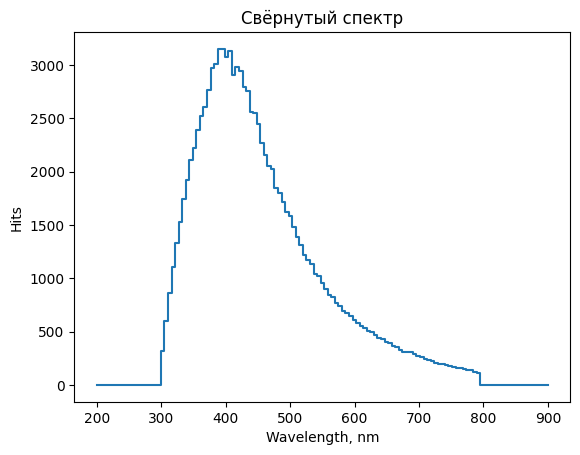

In [73]:
plt.step(PDE_wvs, a1 * PDEs, label='conv')
plt.title('Свёрнутый спектр')
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')
plt.show()

In [169]:
cut_shapes = np.zeros(1000)
for num in range(1000):
    arr = 1239.841 / np.array(file['events;2']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9
    arr = arr[arr > 150]
    arr_bins = np.histogram(arr, bins=a1.shape[0])
    cut_shapes[num] = (arr_bins[0] * PDEs).sum()


KeyError: not found: b'events' with cycle 2
 in file: data\fullsim_optical_1000_pi_500_no.root

In [170]:
cut_shapes = np.zeros(1000)
for num in range(1000):
    arr = 1239.841 / np.array(file['events;1']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9 # for 500
    arr = arr[arr > 150]
    arr_bins = np.histogram(arr, bins=a1.shape[0])
    cut_shapes[num] = (arr_bins[0] * PDEs).sum()


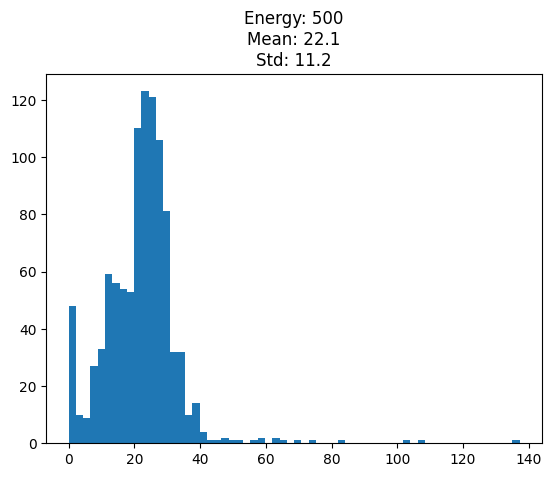

In [171]:
plt.hist(cut_shapes, bins='auto')
plt.title(f'Energy: 500\nMean: {round(cut_shapes.mean(), 1)}' + '\n' + f'Std: {round(cut_shapes.std(), 1)}')
plt.show()

In [160]:
arr_bins = np.histogram(arr, bins=a1.shape[0])

In [161]:
(arr_bins[0] * PDEs).sum() / arr_bins[0].sum()

0.15156340805916513

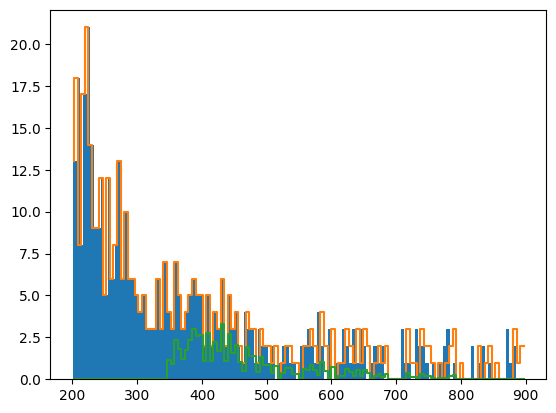

In [162]:
plt.hist(arr, bins=a1.shape[0])
plt.step(PDE_wvs, arr_bins[0])
plt.step(PDE_wvs, arr_bins[0] * PDEs)
plt.show()

In [173]:
mins = np.zeros(1000)
for num in range(1000):
    arr = 1239.841 / np.array(file['events;1']['FarichBarrelG4Hits.energy'].array())[num] * 1e-9 # for 500
    try:
        mins[num] = min(arr)
    except ValueError:
        pass

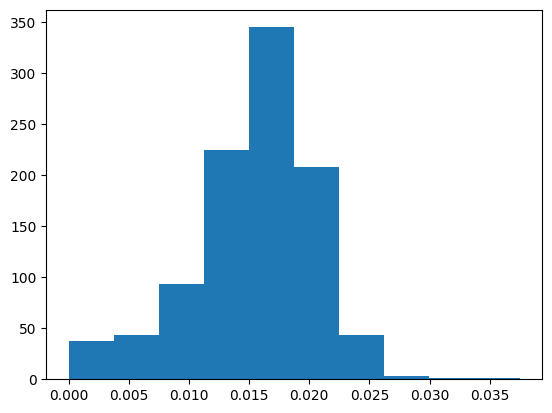

In [174]:
plt.hist(mins)
plt.show()

In [39]:
energies = np.array(file['events;1']['FarichBarrelG4Hits.energy'].array())

In [40]:
energies = np.concatenate(energies)

In [41]:
energies.shape

(460151,)

In [42]:
energies = energies[energies < 1e-7]

In [43]:
energies.shape

(458422,)

In [44]:
energies = energies * 1e9

In [45]:
energies = energies[energies < 7.5]

In [46]:
energies.shape

(458421,)

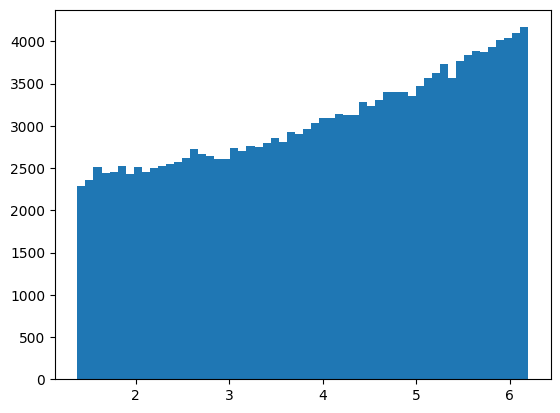

In [199]:
plt.hist(energies[energies < 7.5], bins='auto')
plt.show()

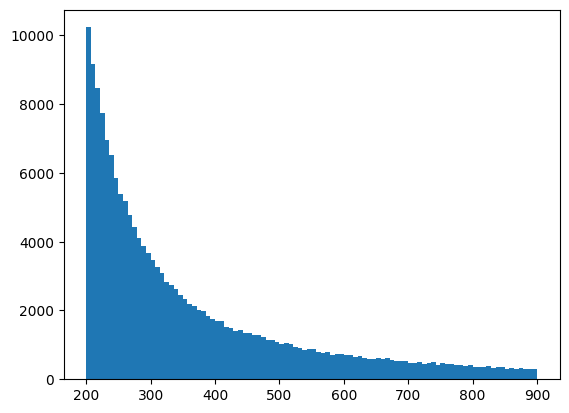

In [202]:
plt.hist(1239.8 / energies,bins='auto')
plt.show()

In [14]:
wavelengths_prototype = np.concatenate(file_prototype['raw_data;2']['event']['m_hits']['m_hits.m_photon_wl'].array())

In [12]:
wavelengths_prototype_1500 = file_prototype['raw_data;2']['event']['m_hits']['m_hits.m_photon_wl'].array()


In [15]:
wavelengths_prototype_1500.shape

(10000,)

In [244]:
wv_res = []
wv_res_len = 0
wv_res_sizes = []

In [245]:
for i in range(wavelengths_prototype_1500.shape[0]):
    if betas_prototype[i] >= 0.99569:
        wv_res.extend(wavelengths_prototype_1500[i])
        wv_res_len += 1
        wv_res_sizes.append(wavelengths_prototype_1500[i].shape[0])

In [246]:
wv_res = np.array(wv_res)
wv_res_sizes = np.array(wv_res_sizes)

In [26]:
print(wv_res.shape[0], wv_res_len, wv_res.shape[0]/wv_res_len)

46411 816 56.87622549019608


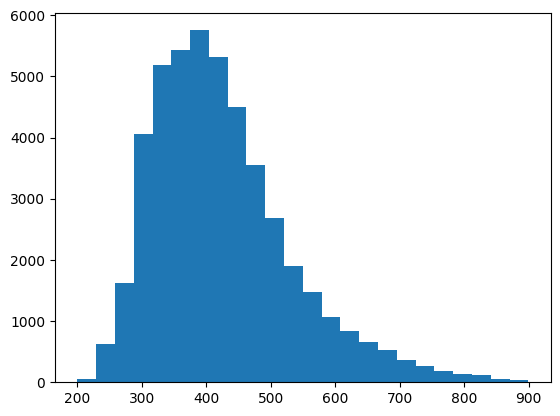

In [28]:
plt.hist(wv_res, bins='doane')
plt.show()

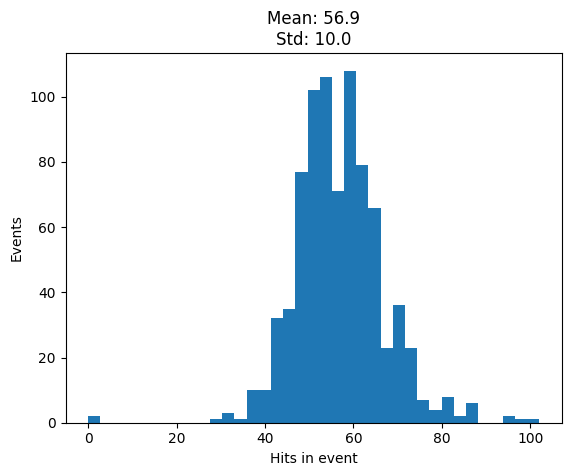

In [251]:
plt.hist(wv_res_sizes, bins='auto')
plt.xlabel('Hits in event')
plt.title(f'Mean: {round(wv_res_sizes.mean(), 1)}' + '\n' + f'Std: {round(wv_res_sizes.std(), 1)}')
plt.ylabel('Events')
plt.show()

In [187]:
mask = betas_prototype >= 0.99569

In [203]:
mask.sum()

816

In [204]:
wv_res.shape[0] / mask.sum()

56.87622549019608

In [16]:
betas_prototype = file_prototype['raw_data;2']['event']['m_beta_primary'].array()

In [190]:
wavelengths_prototype_1500 = wavelengths_prototype_1500[mask]


C:\PYTHON\Python\lib\site-packages\awkward0\array\base.py:622: FutureWarning:

In the future `np.str` will be defined as the corresponding NumPy scalar.



AttributeError: module 'numpy' has no attribute 'str'.
`np.str` was a deprecated alias for the builtin `str`. To avoid this error in existing code, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [178]:
betas_prototype[0]

0.966818333029747

In [173]:
betas_prototype.shape

(10000,)

In [55]:
wavelengths_prototype.shape

(314038,)

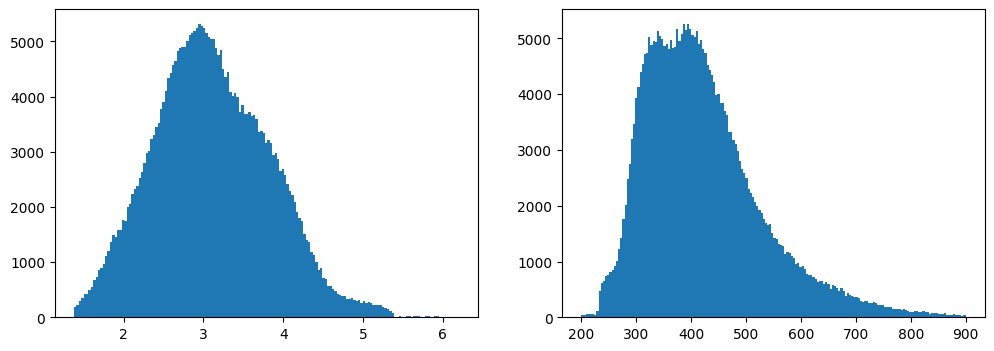

In [59]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(1239.8/wavelengths_prototype, bins='auto', density=False)
plt.subplot(122)
plt.hist(wavelengths_prototype, bins='auto', density=False)
plt.show()

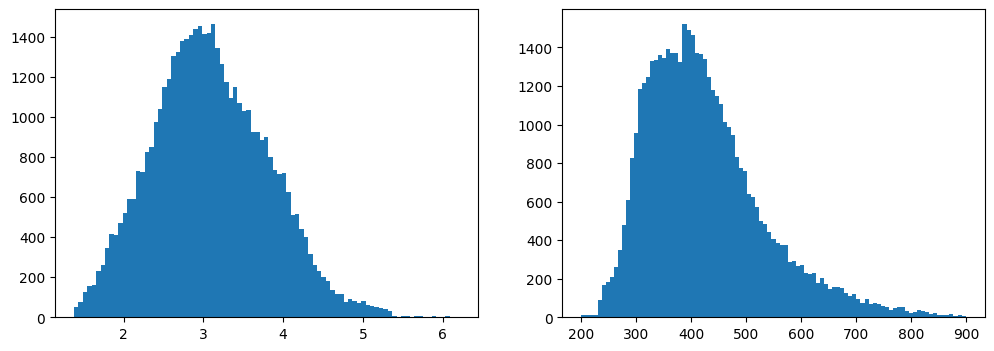

In [205]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(1239.8/wv_res, bins='auto', density=False)
plt.subplot(122)
plt.hist(wv_res, bins='auto', density=False)
plt.show()

In [85]:
xml_energies, xml_r = [], []
xml_data = []
with open(os.path.join(datadir, 'rindex.txt')) as f:
    for line in f:
        xml_data.append(np.array(line.split('*eV '), dtype='float64'))
        # print(np.array(line.split('*eV '), dtype='float64'))
        # break
xml_data = np.array(xml_data)

In [86]:
xml_data.shape

(71, 2)

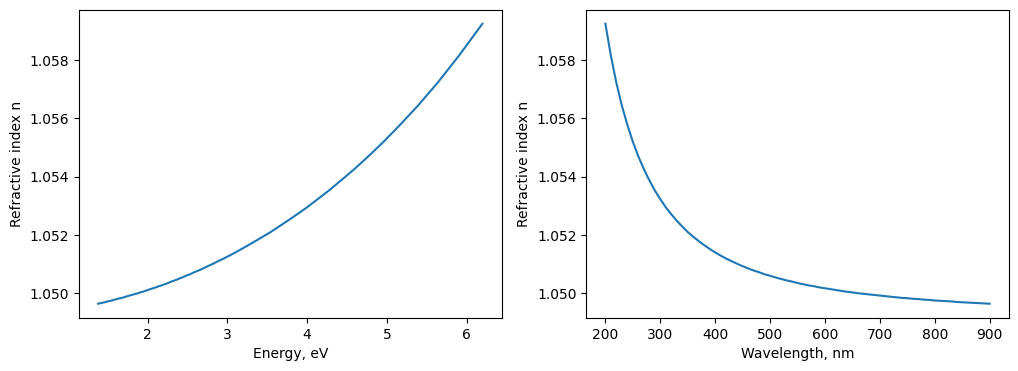

In [10]:
# plt.subplots(1, 2)
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(xml_data[:,0], xml_data[:,1])
plt.xlabel('Energy, eV')
plt.ylabel('Refractive index n')
plt.subplot(122)
plt.plot(1239.8 / xml_data[:,0], xml_data[:,1])
plt.xlabel('Wavelength, nm')
plt.ylabel('Refractive index n')
plt.show()

In [92]:
binned_wavelengths_prototype = np.histogram(wavelengths_prototype, 1239.8 / xml_data[:,0])
binned_wavelengths_full = np.histogram(lambdas, 1239.8 / xml_data[:,0])

binned_energies_prototype = np.histogram(1239.841 / wavelengths_prototype, xml_data[:,0][::-1])

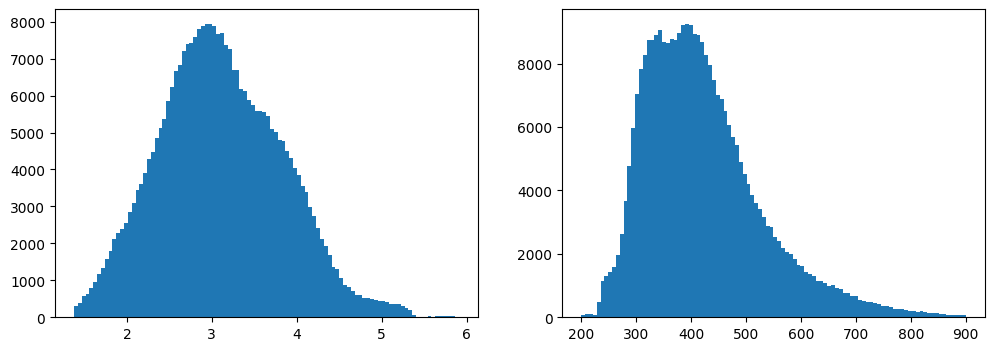

In [110]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(1239.8/wavelengths_prototype, bins= new_bins, density=False)
plt.subplot(122)
plt.hist(wavelengths_prototype, bins= new_wv_bins, density=False)
plt.show()

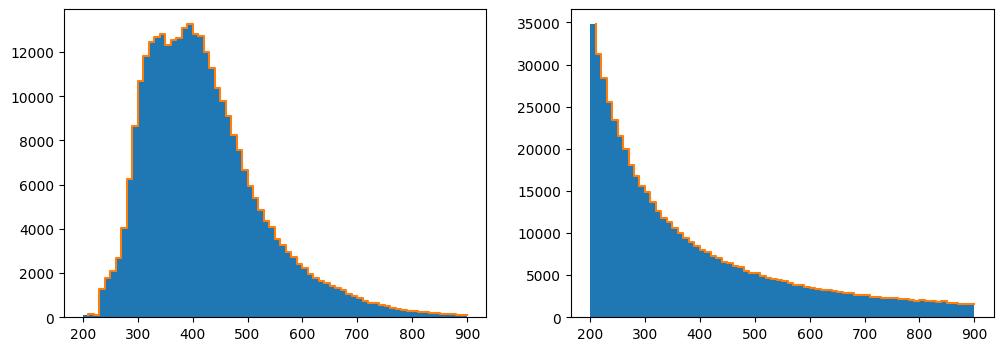

In [66]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(wavelengths_prototype, bins=1239.8 / xml_data[:,0], density=False)
plt.step(binned_wavelengths_prototype[1][1:], binned_wavelengths_prototype[0])

plt.subplot(122)
plt.hist(lambdas, bins=1239.8 / xml_data[:,0], density=False)
plt.step(binned_wavelengths_full[1][1:], binned_wavelengths_full[0])
plt.show()

In [67]:
xml_data[:,1]

array([1.05925, 1.05815, 1.05722, 1.05644, 1.05578, 1.0552 , 1.0547 ,
       1.05426, 1.05388, 1.05353, 1.05323, 1.05295, 1.05271, 1.05249,
       1.05229, 1.0521 , 1.05194, 1.05179, 1.05165, 1.05152, 1.0514 ,
       1.05129, 1.05119, 1.0511 , 1.05101, 1.05093, 1.05085, 1.05078,
       1.05072, 1.05065, 1.0506 , 1.05054, 1.05049, 1.05044, 1.0504 ,
       1.05035, 1.05031, 1.05027, 1.05024, 1.0502 , 1.05017, 1.05014,
       1.05011, 1.05008, 1.05005, 1.05003, 1.05   , 1.04998, 1.04996,
       1.04994, 1.04992, 1.0499 , 1.04988, 1.04986, 1.04984, 1.04983,
       1.04981, 1.0498 , 1.04978, 1.04977, 1.04975, 1.04974, 1.04973,
       1.04972, 1.0497 , 1.04969, 1.04968, 1.04967, 1.04966, 1.04965,
       1.04964])

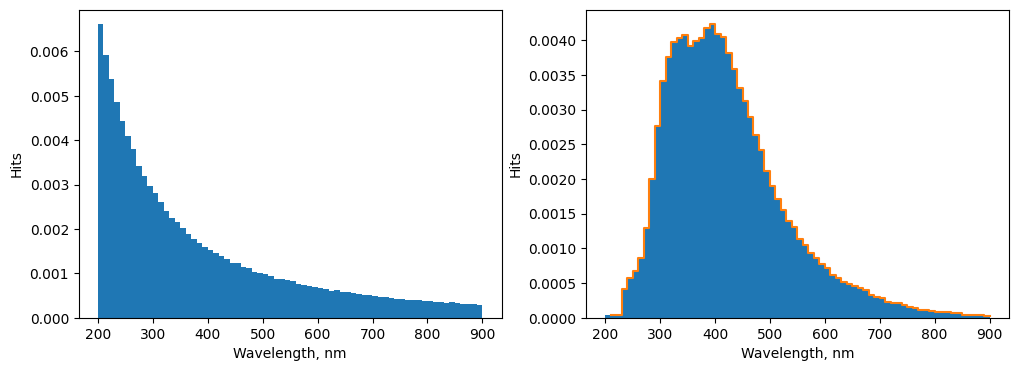

In [80]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(lambdas, bins=1239.8 / xml_data[:,0], density=True, alpha=1)

# plt.hist(wavelengths_prototype, bins=1239.8 / xml_data[:,0], density=True, alpha=0.5)
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')

plt.subplot(122)
plt.hist(wavelengths_prototype, bins=1239.8 / xml_data[:,0], density=True)
plt.step(binned_wavelengths_prototype[1][1:], binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum() / 10)
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')

plt.show()

In [81]:
(binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum() / 10).sum()

0.1

In [86]:
(binned_wavelengths_full[0] / binned_wavelengths_full[0].sum()).sum()

0.9999999999999999

In [89]:
reg = LinearRegression().fit((binned_wavelengths_full[0] / binned_wavelengths_full[0].sum()).reshape(-1, 1), xml_data[:,1][1:])

In [92]:
print(reg.coef_, reg.intercept_)

[0.13432779] 1.0492391744162548


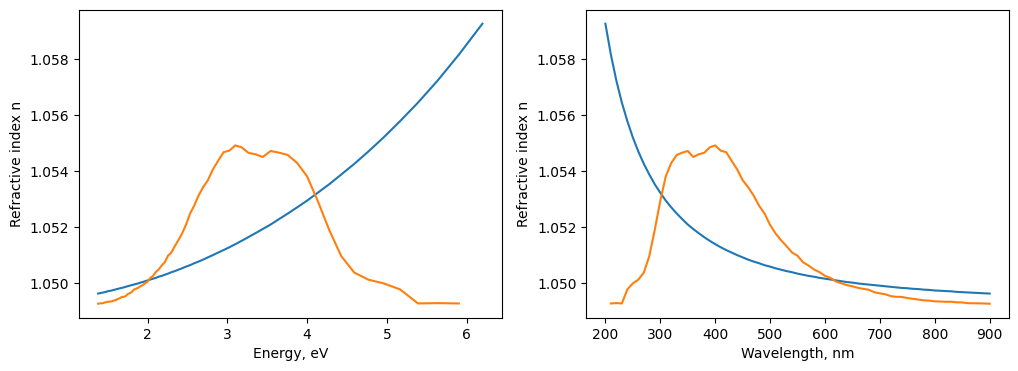

In [112]:

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(xml_data[:,0], xml_data[:,1])
plt.plot(xml_data[:,0][1:], (binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum())*reg.coef_+ reg.intercept_ )
plt.xlabel('Energy, eV')
plt.ylabel('Refractive index n')
plt.subplot(122)
plt.plot(1239.8 / xml_data[:,0], xml_data[:,1])
plt.plot(binned_wavelengths_prototype[1][1:], (binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum())*reg.coef_+ reg.intercept_ )
plt.xlabel('Wavelength, nm')
plt.ylabel('Refractive index n')
plt.show()

In [101]:
out = (binned_wavelengths_prototype[0] / binned_wavelengths_prototype[0].sum())*reg.coef_+ reg.intercept_

In [106]:
out

array([1.04928794, 1.04929991, 1.04928879, 1.04978883, 1.05000398,
       1.05013401, 1.05038681, 1.05097368, 1.05191685, 1.05294258,
       1.05381389, 1.05429297, 1.05457528, 1.05465826, 1.05471772,
       1.05450556, 1.05460094, 1.0546527 , 1.05484604, 1.05491704,
       1.05473012, 1.05467708, 1.05436825, 1.05406199, 1.05367787,
       1.05343021, 1.05312993, 1.05276977, 1.05248404, 1.05208666,
       1.05177954, 1.05153958, 1.05132528, 1.05110285, 1.05098651,
       1.05075638, 1.05063832, 1.05049888, 1.05040264, 1.05027132,
       1.05019732, 1.05006985, 1.05000697, 1.04993982, 1.04989833,
       1.04984443, 1.04980765, 1.04977557, 1.04968574, 1.04964853,
       1.04961388, 1.04954758, 1.04952491, 1.04952063, 1.04947999,
       1.04945347, 1.04942695, 1.04939787, 1.04938931, 1.04936279,
       1.04935638, 1.04934782, 1.04934868, 1.049329  , 1.0493243 ,
       1.04929863, 1.04929393, 1.04929393, 1.04928623, 1.04927853])

In [125]:
with open(os.path.join(datadir, 'rindex_out.txt'), 'w') as f:
    f.write('6.19921*eV 1.04929\n')
    for en, n in zip(xml_data[:,0][1:], out):
        f.write('    {:.5f}*eV {:.5f}\n'.format(round(en, 5), round(n, 5)))


In [8]:
new_bins = np.linspace(1.37760, 5.90401, 101)
new_wv_bins = np.linspace(200, 900, 101)

In [76]:
wavelengths_prototype.shape[0] / betas_prototype.shape[0]

31.4038

In [206]:
wv_res.shape[0] / mask.sum()

56.87622549019608

In [20]:
test_num = 35
filepath_new = os.path.join(datadir, f'fullsim_optical_1000_pi_1500_spectre_test_{test_num}.root')
file_new = uproot.open(filepath_new)
energies_new = np.array(file_new['events;1']['FarichBarrelG4Hits.energy'].array()) * 1e9
energies_new = np.concatenate(energies_new)
energies_new = energies_new[energies_new < 7.5]
lambdas_new = 1239.841 / energies_new
# lambdas_new = np.concatenate(lambdas_new)
# lambdas_new = lambdas_new[lambdas_new > 150]
print(lambdas_new.shape)
print(lambdas_new.shape[0] / np.array(file_new['events;1']['allGenParticles.core.pdgId'].array()).shape[0])

(324251,)
324.251


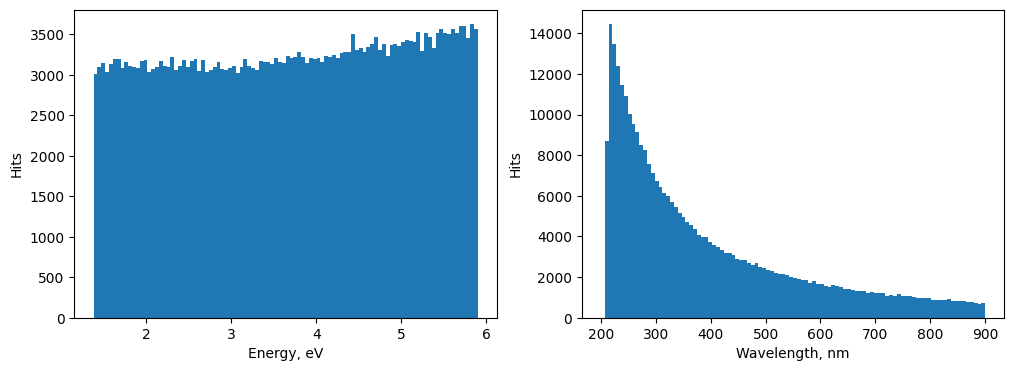

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(energies_new, bins=new_bins)
plt.xlabel('Energy, eV')
plt.ylabel('Hits')
plt.subplot(122)
plt.hist(lambdas_new, bins=new_wv_bins)
plt.xlabel('Wavelength, nm')
plt.ylabel('Hits')
plt.show()

In [ ]:
plot_cyl(file)